<table>
    <tr>
        <td><img src='SystemLink_icon.png' /></td>
        <td ><h1><strong>NI SystemLink Python API</strong></h1></td>
    </tr>
</table>

## Test Monitor Service Example
***
The Test Monitor Service API provides functions to create, update, delete and query Test results and Test steps.
***
# Prerequisites
- The **NI SystemLink  Server Test Module** needs to be installed in order to run this example
- The **NI SystemLink Client** needs to be installed on a system which has TestStand installed and is registered to the SystemLink server.  Configure the SystemLink TestStand plugin reporting to enable publishing test results.
- Before you run this example, TestStand mock test results are needed:
    - From **TestStand** open the **'Computer Motherboard Test Sequence.seq'**:
        - Go to Help -> Find Examples and follow the instructions to open the Examples workspace (Examples.tsw)
        - From the Workspace tab, expand **Demos** and select **Computer Motherboard Test**. Open one of the sequence files, based on your language of choice
    - Run the sequence at least 10 times
        - Make sure you fail several tests, on different components

# Summary 
This notebook uses the Test Monitor Service API to import test and step results into Python. The data is used to do custom analytics.

- Get all the test results that were created from the 'Computer Motherboard Test Sequence.seq' 
- Create a Pandas Dataframe with the information we want to process for each test
- Plot pass vs. fail tests
- Visualize test run vs. test duration
- Pareto graph (step type)
***

In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from systemlink.clientconfig import get_configuration_by_id
from systemlink.clients.nitestmonitor import ApiClient, ResultsApi, ResultsAdvancedQuery, StepsApi, StepsAdvancedQuery

http_client_config = get_configuration_by_id(configuration_id='systemlink_localhost', route_name='nitestmonitor', enable_fallbacks='false')
results_api = ResultsApi(api_client=ApiClient(http_client_config))
steps_api = StepsApi(api_client=ApiClient(http_client_config))

# Create pandas dataframe with the relevant test results information, to be used later
def get_dataframe_from_results(results):
    return pd.concat([pd.DataFrame({'status': result.status.status_type,
                                    'startedAt': result.started_at,
                                    'updatedAt': result.updated_at,
                                    'programName': result.program_name,
                                    'id': result.id,
                                    'systemId': result.system_id,
                                    'operator': result.operator,
                                    'serialNumber': result.serial_number,
                                    'totalTimeInSeconds': result.total_time_in_seconds,
                                    }, index=[idx]) for idx, result in enumerate(results)])

# Only query test results that belong to the 'Computer Motherboard Test Sequence.seq' test program
filter = '(programName == \"Computer Motherboard Test Sequence.seq\")'
query = ResultsAdvancedQuery(filter=filter)
query_response = await results_api.query_results_v2(post_body=query)
results = query_response.results

df_results = get_dataframe_from_results(results)

# Show the first elements of the dataframe, which holds the data we will use for further analysis
df_results[:2]

,status,startedAt,updatedAt,programName,id,systemId,operator,serialNumber,totalTimeInSeconds
0,FAILED,2019-07-03T17:33:52.4751835Z,2019-07-03T17:36:50.8866751Z,Computer Motherboard Test Sequence.seq,8d10299d-7337-4b1a-a7f8-60b6cda09204,VMware7-1--SN-VMware-56_4d_ea_80_35_52_6b_1f-4...,administrator,123456,8.078630
1,PASSED,2019-07-03T17:34:11.7367455Z,2019-07-03T17:36:50.8886587Z,Computer Motherboard Test Sequence.seq,6346d691-1b22-47da-9f7e-9fcc28dbc176,VMware7-1--SN-VMware-56_4d_ea_80_35_52_6b_1f-4...,administrator,123457,2.813866


# Bar Plot of Test Results
Group the tests results by pass/fail. Create a bar plot to visualize the test runs by result.

,startedAt,updatedAt,programName,id,systemId,operator,serialNumber,totalTimeInSeconds
status,,,,,,,,
FAILED,3,3,3,3,3,3,3,3
PASSED,7,7,7,7,7,7,7,7


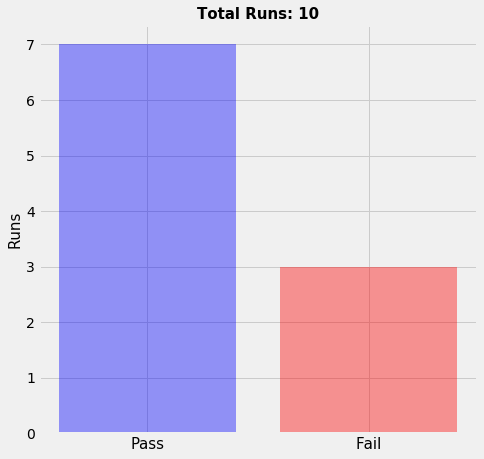

In [10]:
# Visualize tests results (pass/fail)

bar_width = 0.4
opacity = 0.4

res = df_results.groupby('status').count()

display(res)
if 'FAILED' not in res['id']:
    raise RuntimeError('Please ensure that you execute at least one demo test that fails.')

if 'PASSED' not in res['id']:
    raise RuntimeError('Please ensure that you execute at least one demo test that passes.')

failed = res['id']['FAILED']
passed = res['id']['PASSED']

plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(7, 7))
plt.bar(1, passed, bar_width, alpha=opacity, color='b', label='Pass')
plt.bar(1.5, failed, bar_width, alpha=opacity, color='r', label='Fail')
plt.xticks([1, 1.5], ['Pass', 'Fail'], size='15')
plt.ylabel('Runs', size='15')
plt.title('Total Runs: ' + str(passed + failed), weight='bold', size='15')
plt.show()

# Plot Test Run vs. Duration
Visualize the test runs vs. duration, with red/green color indicating pass/fail.

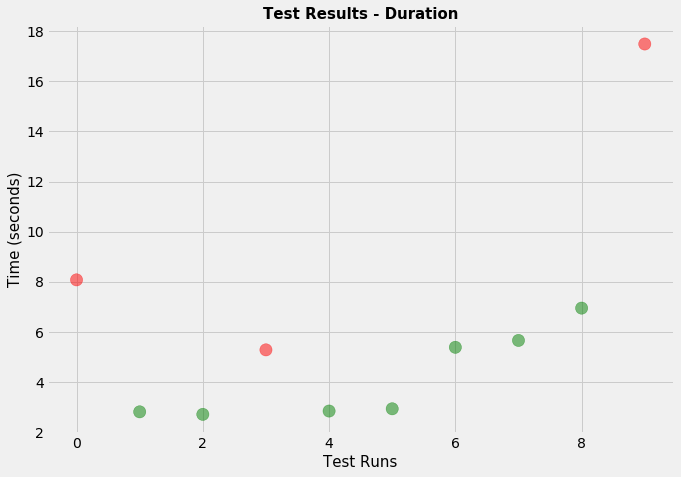

In [11]:
# Visualize test failures vs duration

result_idx = np.arange(df_results.shape[0])

df_time = df_results[['totalTimeInSeconds', 'status']]

color = ['r' if status == 'FAILED' else 'g' for status in df_time['status']]

fig = plt.figure(figsize=(10, 7))
plt.scatter(result_idx, df_time['totalTimeInSeconds'], s=150, c=color, alpha='0.5')
plt.title('Test Results - Duration', weight='bold', size='15')
plt.xlabel('Test Runs', size='15')
plt.ylabel('Time (seconds)', size='15')
plt.show()

# Pareto distribution
Get a Pandas Dataframe with all the step failures. Visualize the failures in a Pareto graph, which helps visualize the failure distribution, by step type.

,id,totalTimeInSeconds
name,,
Keyboard Diagnostics,1,1
Keyboard Test,1,1
Powerup Test,1,1
Video Diagnostics,1,1
Video Test,1,1


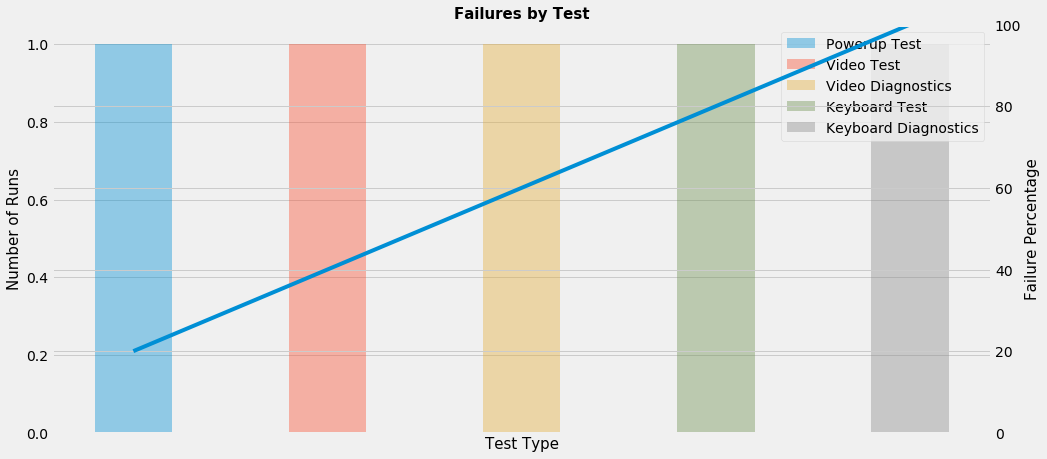

In [12]:
# Pareto distribution of step failures visualization

# Create pandas dataframe with the step results information that we want for further processing
def get_failed_steps_dataframe(steps):
    failed_steps = [step for step in steps if step.status.status_type == 'FAILED' and step.step_type != 'SequenceCall']
    if len(failed_steps) < 1:
        raise RuntimeError('Please ensure that you execute at least one demo test that fails.')
    return pd.concat([pd.DataFrame({'name': step.name,
                                    'id': step.step_id,
                                    'totalTimeInSeconds': step.total_time_in_seconds,
                                    }, index=[idx]) for idx, step in enumerate(failed_steps)])

result_ids = []
step_filter = ''
for result in results:
    result_ids.append(result.to_dict()['id'])
    if step_filter != '':
        step_filter += ' || '
    step_filter += 'resultId == "' + result.to_dict()['id'] + '"'

step_query = StepsAdvancedQuery(filter=step_filter)
step_query_response = await steps_api.query_steps_v2(post_body=step_query)
steps = step_query_response.steps

steps_df = get_failed_steps_dataframe(steps)
res = steps_df.groupby('name').count()
res = res.sort_values('id', ascending=False)
display(res)

fig, ax1 = plt.subplots()
fig.set_size_inches(15, 7)

plt.title('Failures by Test', weight='bold', size='15')
plt.ylabel('Number of Runs', size='15')
plt.xlabel('Test Type', size='15')
ax1.get_xaxis().set_ticks([])

# Create the Pareto chart bars
previous_val = 0
cumulative = []
for idx, row in res.iterrows():
    val = row['id']
    cumulative.append(val + previous_val)
    previous_val = val + previous_val
    ax1.bar(idx, val, bar_width, alpha=opacity, label=idx)

# Add a legend
labels = list(steps_df['name'])
plt.legend(labels, loc='upper right')

# Cumulative line, in percentage
cumulative_percentage = cumulative/cumulative[-1] * 100

ax2 = ax1.twinx()
ax2.set_ylim([0, 100])
ax2.plot(cumulative_percentage)
plt.ylabel('Failure Percentage', size='15')
plt.show()